Test Mean Squared Error: 0.0018


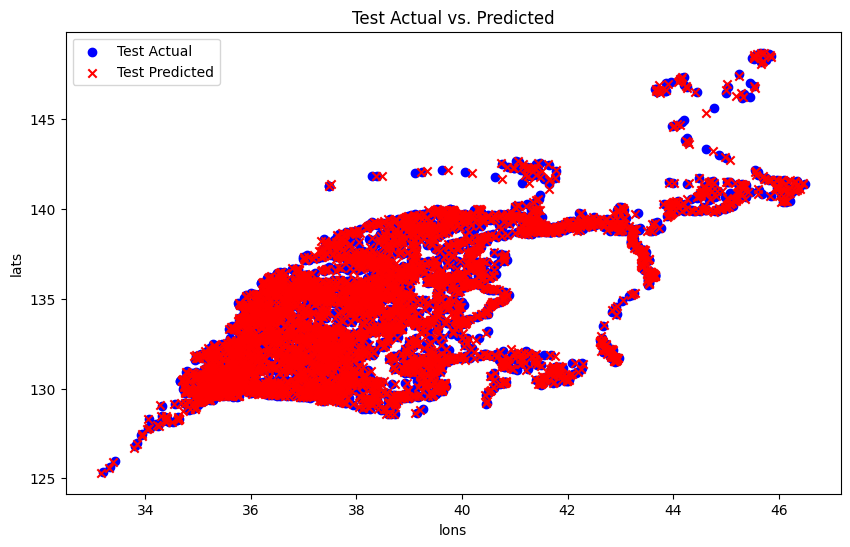

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 데이터 읽기
df = pd.read_csv('data_drifter.csv')

# 데이터 분할
X = df[[ 'lons', 'lats', 'uo', 'vo', 'u10', 'v10']]
y = df[['next_lons', 'next_lats']]

# 데이터를 훈련, 검증 및 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ElasticNet 모델 생성
elasticnet_model = ElasticNet(alpha= 0.01 , l1_ratio=0.1)  # alpha는 전체 규제 강도, l1_ratio는 L1 규제의 비율을 나타냅니다.

# 모델 훈련
elasticnet_model.fit(X_train, y_train)

# 예측
y_pred_test = elasticnet_model.predict(X_test)

# 평가
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Test Mean Squared Error: {mse_test:.4f}")

# Scatter plot으로 테스트 데이터 실제 값과 예측값 표시
plt_y_test = y_test.values
plt.figure(figsize=(10, 6))
plt.scatter(plt_y_test[:, 1], plt_y_test[:, 0], label='Test Actual', c='blue', marker='o')
plt.scatter(y_pred_test[:, 1], y_pred_test[:, 0], label='Test Predicted', c='red', marker='x')
plt.xlabel('lons')
plt.ylabel('lats')
plt.title('Test Actual vs. Predicted')
plt.legend()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

In [3]:
# 데이터 읽기
drifter = pd.read_csv("drifter_2016.csv")

# 시간 변환 함수
def convert_to_nearest_6hour(year, month, day, hour, minute):
    # 데이터 값을 정수형으로 변환
    year = int(year)
    month = int(month)
    day = int(day)
    hour = int(hour)
    minute = int(minute)

    dt = datetime(year, month, day, hour, minute)
    base_dt = datetime(2016, 1, 1, 0, 0)
    delta = dt - base_dt
    
    hours_since_base = delta.total_seconds() / 3600
    nearest_6hour = round(hours_since_base / 6) * 6

    result_time = np.datetime64(base_dt + timedelta(hours=nearest_6hour))

    return nearest_6hour, result_time

# 결과를 저장할 리스트 생성
results = []

# .nc 파일 읽기
dataset_sea = xr.open_dataset('interpolated_sea_2016.nc', engine='netcdf4')
dataset_wind = xr.open_dataset('interpolated_wind_2016.nc', engine='netcdf4')
# 각 시작 지점에 대한 처리
for index, row in drifter.iterrows():
    time, result_time = convert_to_nearest_6hour(row['Year'], row['Month'], row['Day'], row['Hour'], row['Minute'])
    next_time = time + 6
    
    # uo, vo 값을 가져옴
    uo_value = dataset_sea['uo'].sel(time=result_time, longitude=row['Longitude'], latitude=row['Latitude'], method='nearest').item()
    vo_value = dataset_sea['vo'].sel(time=result_time, longitude=row['Longitude'], latitude=row['Latitude'], method='nearest').item()

    # u10, v10 값을 가져옴
    u10_value = dataset_wind['u10'].sel(time=result_time, longitude=row['Longitude'], latitude=row['Latitude'], method='nearest').item()
    v10_value = dataset_wind['v10'].sel(time=result_time, longitude=row['Longitude'], latitude=row['Latitude'], method='nearest').item()

    # 결과 저장
    results.append({
        'time': time,
        'lons': row['Longitude'],
        'lats': row['Latitude'],
        'uo': uo_value,
        'vo': vo_value,
        'u10': u10_value,
        'v10': v10_value,
        'next_time': next_time
    })

dataset_sea.close()
dataset_wind.close()

# 리스트를 DataFrame으로 변환
result_df = pd.DataFrame(results)

In [6]:
# 각 시작 지점에서의 100일간 예측
predict_duration = 400  # 100일 * 4 (하루에 6시간 단위로 1번 예측)

# 예측 결과를 저장할 DataFrame
predictions_df = pd.DataFrame(columns=['time', 'lons', 'lats', 'uo', 'vo', 'u10', 'v10', 'next_time', 'next_lons', 'next_lats'])

# .nc 파일 읽기
dataset_sea = xr.open_dataset('interpolated_sea_2016.nc', engine='netcdf4')
dataset_wind = xr.open_dataset('interpolated_wind_2016.nc', engine='netcdf4')

# 각 시작 지점 별로 for loop
for index, row in result_df.iterrows():  # 여기서 df는 시작 데이터 프레임입니다.
    print(f"Predicting for index {index}...")

    # 초기값 불러오기
    current_time = row['time']
    current_lon = row['lons']
    current_lat = row['lats']
    uo_value = row['uo']
    vo_value = row['vo']
    u10_value = row['u10']
    v10_value = row['v10']
    next_time = row['next_time']
    print(f"Initial value load for index {index}...")
    print(f"result : {current_time}, {current_lon}, {current_lat}, {uo_value}, {vo_value}, {u10_value}, {v10_value}, {next_time}")
    predictions_list = []

    # 100일간 예측
    for _ in range(predict_duration):
        # 모델에 입력값을 넣어 다음 위치를 예측합니다.
        input_data = np.array([[current_lon, current_lat, uo_value, vo_value, u10_value, v10_value]])
        input_data = input_data.reshape((input_data.shape[0], input_data.shape[1]))  # 2D 배열로 변환
        
        # 값 중에 NaN이 있는지 확인
        values_to_check = [current_time, current_lon, current_lat, uo_value, vo_value, u10_value, v10_value, next_time]
        if any(np.isnan(value) for value in values_to_check):
            print("Encountered a NaN value. Stopping the prediction loop.")
            break
        
        prediction = elasticnet_model.predict(input_data)

        # 예측된 위치를 업데이트
        predicted_lon = prediction[0][0]
        predicted_lat = prediction[0][1]

        predictions_list.append({
            'time': current_time,
            'lons': current_lon,
            'lats': current_lat,
            'uo': uo_value,
            'vo': vo_value,
            'u10': u10_value,
            'v10': v10_value,
            'next_time': next_time,
            'next_lons': predicted_lon,
            'next_lats': predicted_lat
        })

        # 다음 반복을 위한 현재 위치와 시간 업데이트
        current_lon = predicted_lon
        current_lat = predicted_lat
        current_time += 6  # 6시간 뒤로 이동
        next_time += 6  # 6시간 뒤로 이동

        # 위도 경도 값을 가져오기 위한 시간 변환
        base_dt = datetime(2016, 1, 1, 0, 0)
        search_time = np.datetime64(base_dt + timedelta(hours=current_time))

        # 현재 위치와 시간을 기반으로 uo, vo, u10, v10 값을 가져옵니다.
        uo_value = dataset_sea['uo'].sel(time=search_time, longitude=current_lon, latitude=current_lat, method='nearest').item()
        vo_value = dataset_sea['vo'].sel(time=search_time, longitude=current_lon, latitude=current_lat, method='nearest').item()
        u10_value = dataset_wind['u10'].sel(time=search_time, longitude=current_lon, latitude=current_lat, method='nearest').item()
        v10_value = dataset_wind['v10'].sel(time=search_time, longitude=current_lon, latitude=current_lat, method='nearest').item()

    # 리스트를 DataFrame으로 변환
    predictions_df = pd.DataFrame(predictions_list)
    predictions_df.to_csv(f"predictions_{index}.csv", index=False)
    print(f"Predictions for index {index} completed.")


dataset_sea.close()
dataset_wind.close()

Predicting for index 0...
Initial value load for index 0...
result : 1740.0, 127.07183333333332, 32.50736666666667, -0.042593646328896284, 0.16361024975776672, -3.69885516166687, -5.244993209838867, 1746.0


C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with featur

Predictions for index 0 completed.
Predicting for index 1...
Initial value load for index 1...
result : 1794.0, 126.61581666666666, 33.75931666666666, 0.11165913939476013, 0.15635666251182556, -1.9890496730804443, -1.6702220439910889, 1800.0


C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with featur

Encountered a NaN value. Stopping the prediction loop.
Predictions for index 1 completed.
Predicting for index 2...
Initial value load for index 2...
result : 1884.0, 129.28193333333334, 34.94963333333333, -0.03971831128001213, 0.28822505474090576, -6.011956214904785, -6.2450361251831055, 1890.0
Encountered a NaN value. Stopping the prediction loop.
Predictions for index 2 completed.
Predicting for index 3...
Initial value load for index 3...
result : 1884.0, 129.2124, 34.986666666666665, -0.040380340069532394, 0.27208882570266724, -4.942860126495361, -5.878522872924805, 1890.0
Encountered a NaN value. Stopping the prediction loop.
Predictions for index 3 completed.
Predicting for index 4...
Initial value load for index 4...
result : 4722.0, 127.07446666666668, 32.51626666666667, 0.049979022704064846, 0.30493471026420593, -2.538095712661743, 6.6215009689331055, 4728.0


C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with featur

Encountered a NaN value. Stopping the prediction loop.
Predictions for index 4 completed.
Predicting for index 5...
Initial value load for index 5...
result : 4788.0, 129.29723333333334, 34.92175, 0.2030828446149826, 0.3891388177871704, 1.0723252296447754, 2.255833148956299, 4794.0


C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with featur

Predictions for index 5 completed.
Predicting for index 6...
Initial value load for index 6...
result : 4824.0, 129.39828333333332, 37.55258333333333, 0.025877391919493675, 0.015027848072350025, -3.240537643432617, 1.6537771224975586, 4830.0


C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with featur

Predictions for index 6 completed.


C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\in_q\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with featur